<h3>SIMO point-to-point link between a mobile user terminal (UT) and a base station (BS).</h3>

In [1]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

import numpy as np

# For plotting
%matplotlib inline
import matplotlib.pyplot as plt

# For the implementation of the Keras models
from tensorflow.keras import Model

# Set seed for reproducable results
sn.config.seed = 42

In [2]:
# Define the number of UT and BS antennas
NUM_UT = 1
NUM_BS = 1
NUM_UT_ANT = 1
NUM_BS_ANT = 4

# The number of transmitted streams is equal to the number of UT antennas
# in both uplink and downlink
NUM_STREAMS_PER_TX = NUM_UT_ANT

# Create an RX-TX association matrix.
# RX_TX_ASSOCIATION[i,j]=1 means that receiver i gets at least one stream
# from transmitter j. Depending on the transmission direction (uplink or downlink),
# the role of UT and BS can change.
# For example, considering a system with 2 RX and 4 TX, the RX-TX
# association matrix could be
# [ [1 , 1, 0, 0],
#   [0 , 0, 1, 1] ]
# which indicates that the RX 0 receives from TX 0 and 1, and RX 1 receives from
# TX 2 and 3.
#
# In this notebook, as we have only a single transmitter and receiver,
# the RX-TX association matrix is simply:
RX_TX_ASSOCIATION = np.array([[1]])

# Instantiate a StreamManagement object
# This determines which data streams are determined for which receiver.
# In this simple setup, this is fairly easy. However, it can get more involved
# for simulations with many transmitters and receivers.
STREAM_MANAGEMENT = sn.mimo.StreamManagement(RX_TX_ASSOCIATION, NUM_STREAMS_PER_TX)

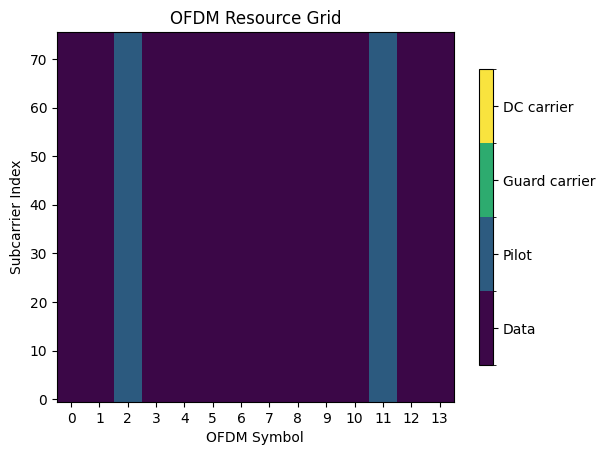

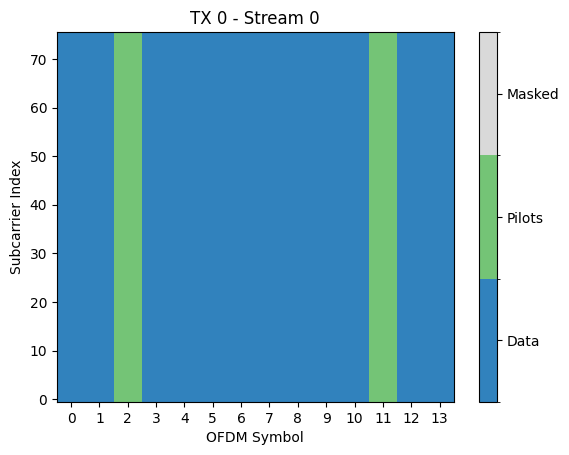

In [3]:
RESOURCE_GRID = sn.ofdm.ResourceGrid( num_ofdm_symbols=14,
                                      fft_size=76,
                                      subcarrier_spacing=30e3,
                                      num_tx=NUM_UT,
                                      num_streams_per_tx=NUM_STREAMS_PER_TX,
                                      cyclic_prefix_length=6,
                                      pilot_pattern="kronecker",
                                      pilot_ofdm_symbol_indices=[2,11])
RESOURCE_GRID.show();
RESOURCE_GRID.pilot_pattern.show();

In [4]:
NUM_BITS_PER_SYMBOL = 2 # QPSK
CODERATE = 0.5

# Number of coded bits in a resource grid
n = int(RESOURCE_GRID.num_data_symbols*NUM_BITS_PER_SYMBOL)
# Number of information bits in a resource groud
k = int(n*CODERATE)

# The binary source will create batches of information bits
binary_source = sn.utils.BinarySource()


In [5]:
binary_source

In [6]:

# The encoder maps information bits to coded bits
encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# The mapper maps blocks of information bits to constellation symbols
mapper = sn.mapping.Mapper("qam", NUM_BITS_PER_SYMBOL)


# The resource grid mapper maps symbols onto an OFDM resource grid
rg_mapper = sn.ofdm.ResourceGridMapper(RESOURCE_GRID)

# Frequency domain channel
channel = sn.channel.AWGN()

# The LS channel estimator will provide channel estimates and error variances
ls_est = sn.ofdm.LSChannelEstimator(RESOURCE_GRID, interpolation_type="nn")

# The LMMSE equalizer will provide soft symbols together with noise variance estimates
lmmse_equ = sn.ofdm.LMMSEEqualizer(RESOURCE_GRID, STREAM_MANAGEMENT)

# The demapper produces LLR for all coded bits
demapper = sn.mapping.Demapper("app", "qam", NUM_BITS_PER_SYMBOL)

# The decoder provides hard-decisions on the information bits
decoder = sn.fec.ldpc.LDPC5GDecoder(encoder, hard_out=True)

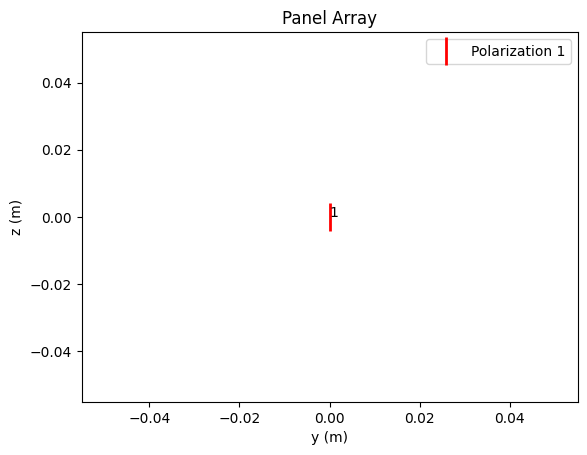

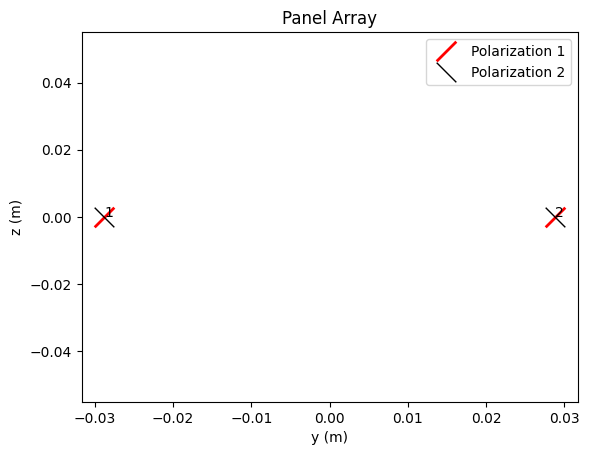

In [7]:
CARRIER_FREQUENCY = 2.6e9 # Carrier frequency in Hz.
                          # This is needed here to define the antenna element spacing.

UT_ARRAY = sn.channel.tr38901.Antenna(  polarization="single",
                                        polarization_type="V",
                                        antenna_pattern="38.901",
                                        carrier_frequency=CARRIER_FREQUENCY)
UT_ARRAY.show();

BS_ARRAY = sn.channel.tr38901.AntennaArray( num_rows=1,
                                            num_cols=int(NUM_BS_ANT/2),
                                            polarization="dual",
                                            polarization_type="cross",
                                            antenna_pattern="38.901", # Try 'omni'
                                            carrier_frequency=CARRIER_FREQUENCY)
BS_ARRAY.show();



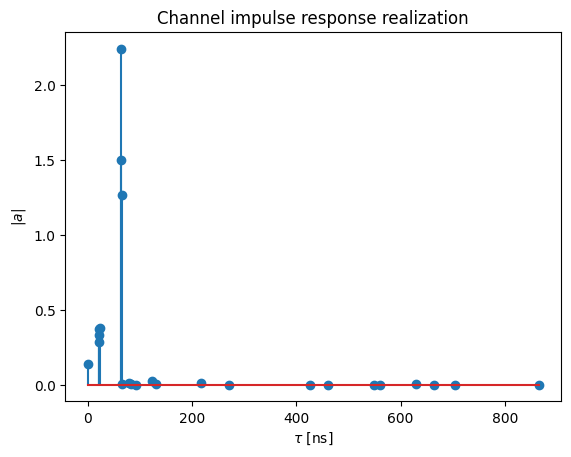

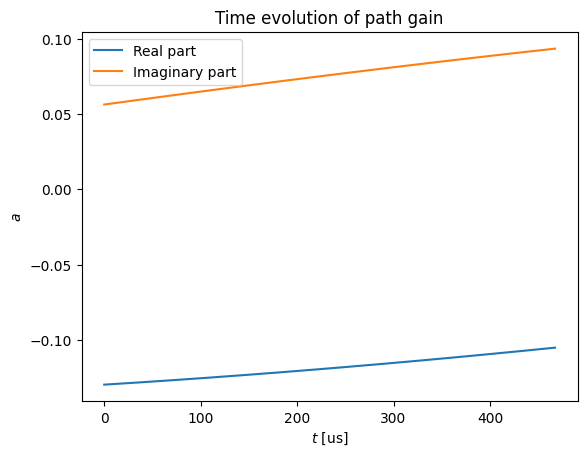

In [28]:
DELAY_SPREAD = 100e-9 # Nominal delay spread in [s]. Please see the CDL documentation
                      # about how to choose this value.

DIRECTION = "uplink"  # The `direction` determines if the UT or BS is transmitting.
                      # In the `uplink`, the UT is transmitting.

CDL_MODEL = "C"       # Suitable values are ["A", "B", "C", "D", "E"]

SPEED = 20.0          # UT speed [m/s]. BSs are always assumed to be fixed.
                     # The direction of travel will chosen randomly within the x-y plane.

# Configure a channel impulse reponse (CIR) generator for the CDL model.
CDL = sn.channel.tr38901.CDL(CDL_MODEL,
                             DELAY_SPREAD,
                             CARRIER_FREQUENCY,
                             UT_ARRAY,
                             BS_ARRAY,
                             DIRECTION,
                             min_speed=SPEED)

BATCH_SIZE = 128 # How many examples are processed by Sionna in parallel

a, tau = CDL(batch_size=BATCH_SIZE,
             num_time_steps=RESOURCE_GRID.num_ofdm_symbols,
             sampling_frequency=1/RESOURCE_GRID.ofdm_symbol_duration)

plt.figure()
plt.title("Channel impulse response realization")
plt.stem(tau[0,0,0,:]/1e-9, np.abs(a)[0,0,0,0,0,:,0])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$")


plt.figure()
plt.title("Time evolution of path gain")
plt.plot(np.arange(RESOURCE_GRID.num_ofdm_symbols)*RESOURCE_GRID.ofdm_symbol_duration/1e-6, np.real(a)[0,0,0,0,0,0,:])
plt.plot(np.arange(RESOURCE_GRID.num_ofdm_symbols)*RESOURCE_GRID.ofdm_symbol_duration/1e-6, np.imag(a)[0,0,0,0,0,0,:])
plt.legend(["Real part", "Imaginary part"])

plt.xlabel(r"$t$ [us]")
plt.ylabel(r"$a$");

In [14]:
print("Shape of the path gains: ", a.shape)
print("Shape of the delays:", tau.shape)

Shape of the path gains:  (128, 1, 1, 1, 4, 24, 14)
Shape of the delays: (128, 1, 1, 24)


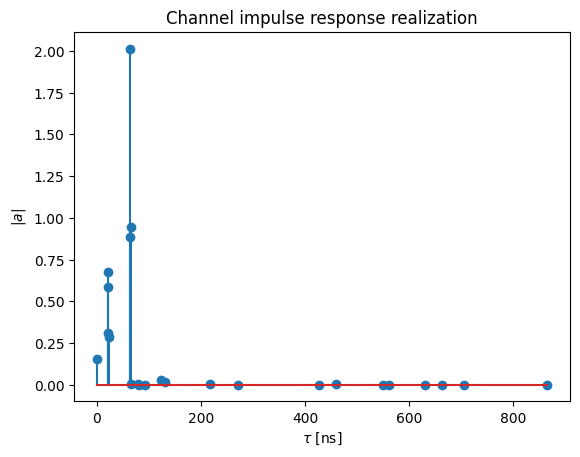

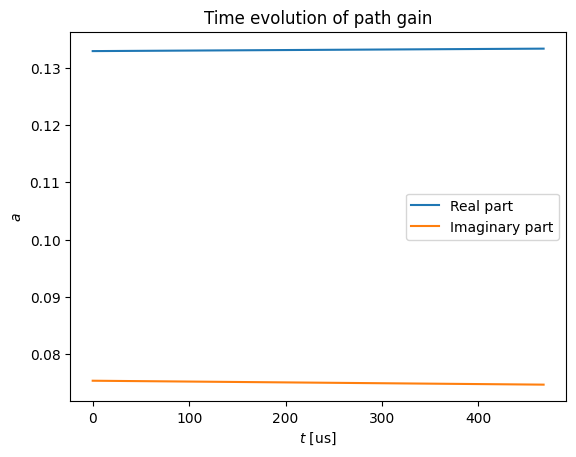

In [12]:
NUM_BITS_PER_SYMBOL = 2 # QPSK
CODERATE = 0.5

# Number of coded bits in a resource grid
n = int(RESOURCE_GRID.num_data_symbols*NUM_BITS_PER_SYMBOL)
# Number of information bits in a resource groud
k = int(n*CODERATE)

# The binary source will create batches of information bits
binary_source = sn.utils.BinarySource()

# The encoder maps information bits to coded bits
encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# The mapper maps blocks of information bits to constellation symbols
mapper = sn.mapping.Mapper("qam", NUM_BITS_PER_SYMBOL)

# The resource grid mapper maps symbols onto an OFDM resource grid
rg_mapper = sn.ofdm.ResourceGridMapper(RESOURCE_GRID)

# Frequency domain channel
channel = sn.channel.OFDMChannel(CDL, RESOURCE_GRID, add_awgn=True, normalize_channel=True, return_channel=True)

# The LS channel estimator will provide channel estimates and error variances
ls_est = sn.ofdm.LSChannelEstimator(RESOURCE_GRID, interpolation_type="nn")

# The LMMSE equalizer will provide soft symbols together with noise variance estimates
lmmse_equ = sn.ofdm.LMMSEEqualizer(RESOURCE_GRID, STREAM_MANAGEMENT)

# The demapper produces LLR for all coded bits
demapper = sn.mapping.Demapper("app", "qam", NUM_BITS_PER_SYMBOL)

# The decoder provides hard-decisions on the information bits
decoder = sn.fec.ldpc.LDPC5GDecoder(encoder, hard_out=True)

In [13]:
no = sn.utils.ebnodb2no(ebno_db=10.0,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=CODERATE,
                        resource_grid=RESOURCE_GRID)

# Transmitter
bits = binary_source([BATCH_SIZE, NUM_UT, RESOURCE_GRID.num_streams_per_tx, k])


In [56]:
bits

<tf.Tensor: shape=(128, 1, 1, 912), dtype=float32, numpy=
array([[[[1., 1., 0., ..., 0., 1., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 1.]]],


       [[[1., 1., 0., ..., 0., 0., 1.]]],


       ...,


       [[[1., 1., 0., ..., 0., 1., 0.]]],


       [[[0., 0., 1., ..., 1., 1., 0.]]],


       [[[0., 1., 1., ..., 0., 1., 1.]]]], dtype=float32)>

In [14]:
print("Shape of bits: ", bits.shape)
codewords = encoder(bits)
print("Shape of codewords: ", codewords.shape)
x = mapper(codewords)
print("Shape of x: ", x.shape)
x_rg = rg_mapper(x)
print("Shape of x_rg: ", x_rg.shape)

# Channel
y, h_freq = channel([x_rg, no])
print("Shape of y_rg: ", y.shape)
print("Shape of h_freq: ", h_freq.shape)

# Receiver
h_hat, err_var = ls_est ([y, no])
print("Shape of h_hat: ", h_hat.shape)
print("Shape of err_var: ", err_var.shape)
x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
print("Shape of x_hat: ", x_hat.shape)
print("Shape of no_eff: ", no_eff.shape)
llr = demapper([x_hat, no_eff])
print("Shape of llr: ", llr.shape)
bits_hat = decoder(llr)
print("Shape of bits_hat: ", bits_hat.shape)

Shape of bits:  (128, 1, 1, 912)
Shape of codewords:  (128, 1, 1, 1824)
Shape of x:  (128, 1, 1, 912)
Shape of x_rg:  (128, 1, 1, 14, 76)
Shape of y_rg:  (128, 1, 4, 14, 76)
Shape of h_freq:  (128, 1, 4, 1, 1, 14, 76)
Shape of h_hat:  (128, 1, 4, 1, 1, 14, 76)
Shape of err_var:  (1, 1, 1, 1, 1, 14, 76)
Shape of x_hat:  (128, 1, 1, 912)
Shape of no_eff:  (128, 1, 1, 912)
Shape of llr:  (128, 1, 1, 1824)
Shape of bits_hat:  (128, 1, 1, 912)


In [15]:
class OFDMSystem(Model): # Inherits from Keras Model

    def __init__(self, perfect_csi):
        super().__init__() # Must call the Keras model initializer

        self.perfect_csi = perfect_csi

        n = int(RESOURCE_GRID.num_data_symbols*NUM_BITS_PER_SYMBOL) # Number of coded bits
        k = int(n*CODERATE) # Number of information bits
        self.k = k

        # The binary source will create batches of information bits
        self.binary_source = sn.utils.BinarySource()

        # The encoder maps information bits to coded bits
        self.encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

        # The mapper maps blocks of information bits to constellation symbols
        self.mapper = sn.mapping.Mapper("qam", NUM_BITS_PER_SYMBOL)

        # The resource grid mapper maps symbols onto an OFDM resource grid
        self.rg_mapper = sn.ofdm.ResourceGridMapper(RESOURCE_GRID)

        # Frequency domain channel
        self.channel = sn.channel.OFDMChannel(CDL, RESOURCE_GRID, add_awgn=True, normalize_channel=True, return_channel=True)

        # The LS channel estimator will provide channel estimates and error variances
        self.ls_est = sn.ofdm.LSChannelEstimator(RESOURCE_GRID, interpolation_type="nn")

        # The LMMSE equalizer will provide soft symbols together with noise variance estimates
        self.lmmse_equ = sn.ofdm.LMMSEEqualizer(RESOURCE_GRID, STREAM_MANAGEMENT)

        # The demapper produces LLR for all coded bits
        self.demapper = sn.mapping.Demapper("app", "qam", NUM_BITS_PER_SYMBOL)

        # The decoder provides hard-decisions on the information bits
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=True)

    @tf.function # Graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=NUM_BITS_PER_SYMBOL, coderate=CODERATE, resource_grid=RESOURCE_GRID)

        # Transmitter
        bits = self.binary_source([batch_size, NUM_UT, RESOURCE_GRID.num_streams_per_tx, self.k])
        codewords = self.encoder(bits)
        x = self.mapper(codewords)
        x_rg = self.rg_mapper(x)

        # Channel
        y, h_freq = self.channel([x_rg, no])

        # Receiver
        if self.perfect_csi:
            h_hat, err_var = h_freq, 0.
        else:
            h_hat, err_var = self.ls_est ([y, no])
        x_hat, no_eff = self.lmmse_equ([y, h_hat, err_var, no])
        llr = self.demapper([x_hat, no_eff])
        bits_hat = self.decoder(llr)

        return bits, bits_hat
    
    def transmit(self, batch_size, ebno_db):
            bits, bits_hat = self(batch_size, ebno_db)  # Calls __call__ method internally
            return bits.numpy(), bits_hat.numpy()  # Convert tensors to NumPy arrays

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -8.0 | 4.3035e-01 | 1.0000e+00 |       50237 |      116736 |          128 |         128 |         5.6 |reached target block errors
   -7.421 | 4.2089e-01 | 1.0000e+00 |       49133 |      116736 |          128 |         128 |         0.2 |reached target block errors
   -6.842 | 4.0998e-01 | 1.0000e+00 |       47860 |      116736 |          128 |         128 |         0.3 |reached target block errors
   -6.263 | 4.0063e-01 | 1.0000e+00 |       46768 |      116736 |          128 |         128 |         0.2 |reached target block errors
   -5.684 | 3.8746e-01 | 1.0000e+00 |       45231 |      116736 |          128 |         128 |         0.2 |reached target block errors
   -5.105 | 3.7554e-01 | 1.0000e+00 |       43839 |      116736 |

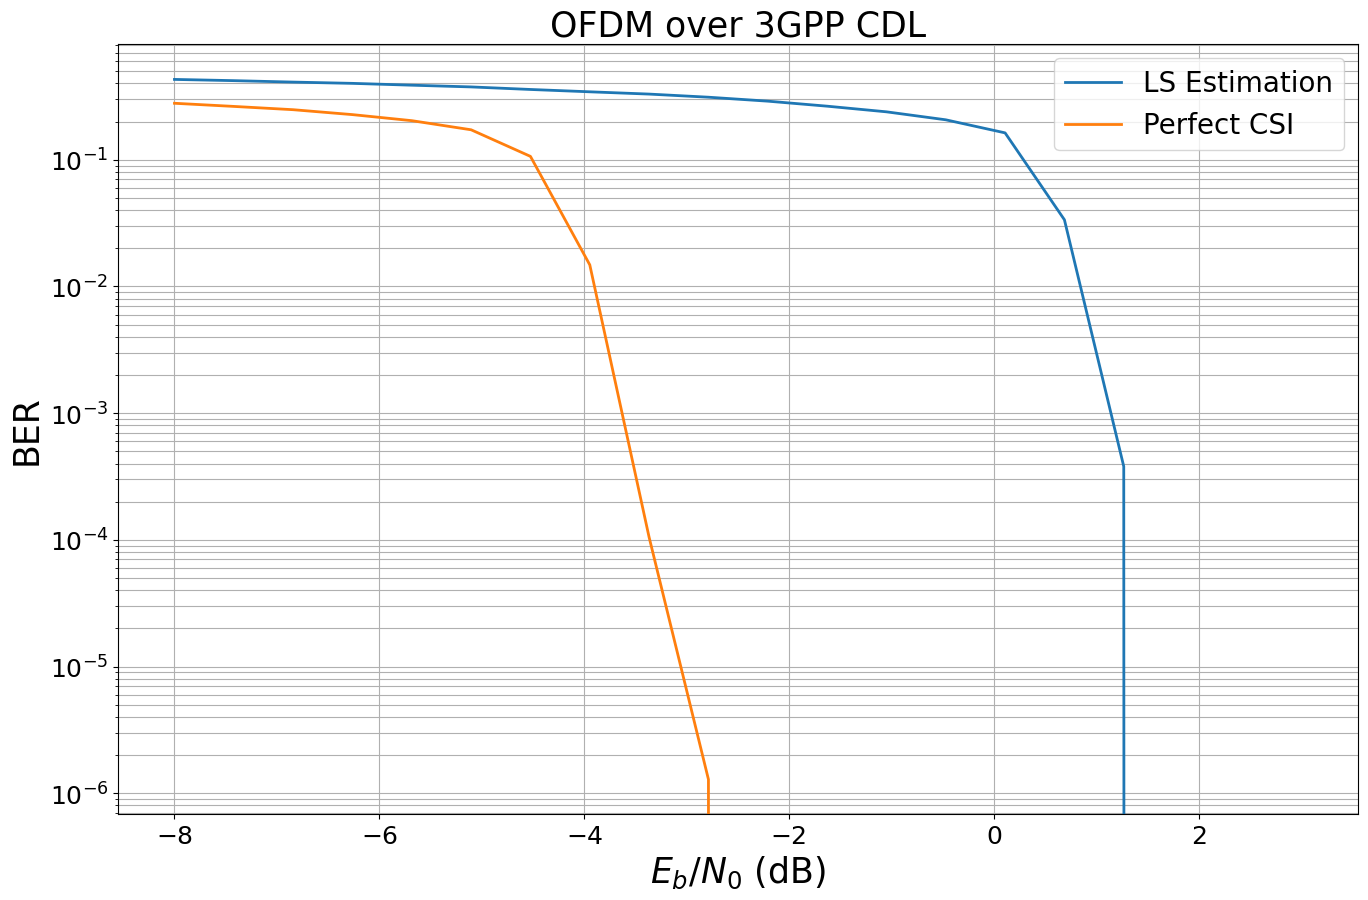

In [16]:
EBN0_DB_MIN = -8.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 3.0 # Maximum value of Eb/N0 [dB] for simulations

ber_plots = sn.utils.PlotBER("OFDM over 3GPP CDL")

model_ls = OFDMSystem(False)
ber_plots.simulate(model_ls,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="LS Estimation",
                  soft_estimates=True,
                  max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=False);

model_pcsi = OFDMSystem(True)
ber_plots.simulate(model_pcsi,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="Perfect CSI",
                  soft_estimates=True,
                  max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=False);

ber_plots();

<h3>Now use the above system to transmit an image</h3>

In [17]:
def preprocess_image(image, k):
    """Preprocess an image: resize, convert to grayscale if needed, and flatten into binary bits."""
    if len(image.shape) == 3:  # Convert color image to grayscale
        image = rgb2gray(image)
    image = resize(image, (128, 128), anti_aliasing=True)  # Resize for simplicity
    image = (image * 255).astype(np.uint8)  # Scale to 0-255
    flat_bits = np.unpackbits(image.flatten())
    # Pad to match the system's input size
    num_bits = len(flat_bits)
    pad_bits = (k - (num_bits % k)) % k
    flat_bits = np.pad(flat_bits, (0, pad_bits), 'constant')
    return flat_bits, image.shape

def reconstruct_image(bits, shape):
    """Reconstruct an image from binary bits and reshape to original dimensions."""
    num_pixels = np.prod(shape)
    pixels = np.packbits(bits[:num_pixels])
    img_array = pixels.reshape(shape)
    return Image.fromarray(img_array.astype(np.uint8))

from skimage import data
model = OFDMSystem(perfect_csi=True)
flat_img, img_shape = preprocess_image(data.camera() , model.k)

ModuleNotFoundError: No module named 'skimage'

In [66]:
flat_img.shape

(131328,)

In [23]:
class AWGNSystem(Model):  # Inherits from Keras Model

    def __init__(self):
        super().__init__()  # Must call the Keras model initializer

        n = int(RESOURCE_GRID.num_data_symbols * NUM_BITS_PER_SYMBOL)  # Number of coded bits
        k = int(n * CODERATE)  # Number of information bits
        self.k = k

        # The binary source will create batches of information bits
        self.binary_source = sn.utils.BinarySource()

        # The encoder maps information bits to coded bits
        self.encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

        # The mapper maps blocks of information bits to constellation symbols
        self.mapper = sn.mapping.Mapper("qam", NUM_BITS_PER_SYMBOL)

        # AWGN channel
        self.channel = sn.channel.AWGN()

        # The demapper produces LLR for all coded bits
        self.demapper = sn.mapping.Demapper("app", "qam", NUM_BITS_PER_SYMBOL)

        # The decoder provides hard-decisions on the information bits
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=True)

    @tf.function  # Graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        # Convert Eb/N0 to noise power spectral density
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=NUM_BITS_PER_SYMBOL, coderate=CODERATE)

        # Transmitter
        bits = self.binary_source([batch_size, self.k])
        codewords = self.encoder(bits)
        x = self.mapper(codewords)

        # Channel
        y = self.channel([x, no])

        # Receiver
        llr = self.demapper([y, no])
        bits_hat = self.decoder(llr)

        return bits, bits_hat


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -8.0 | 3.7618e-01 | 1.0000e+00 |       43914 |      116736 |          128 |         128 |         0.6 |reached target block errors
   -6.947 | 3.6115e-01 | 1.0000e+00 |       42159 |      116736 |          128 |         128 |         0.1 |reached target block errors
   -5.895 | 3.4220e-01 | 1.0000e+00 |       39947 |      116736 |          128 |         128 |         0.1 |reached target block errors
   -4.842 | 3.2487e-01 | 1.0000e+00 |       37924 |      116736 |          128 |         128 |         0.1 |reached target block errors
   -3.789 | 3.0024e-01 | 1.0000e+00 |       35049 |      116736 |          128 |         128 |         0.1 |reached target block errors
   -2.737 | 2.7487e-01 | 1.0000e+00 |       32087 |      116736 |

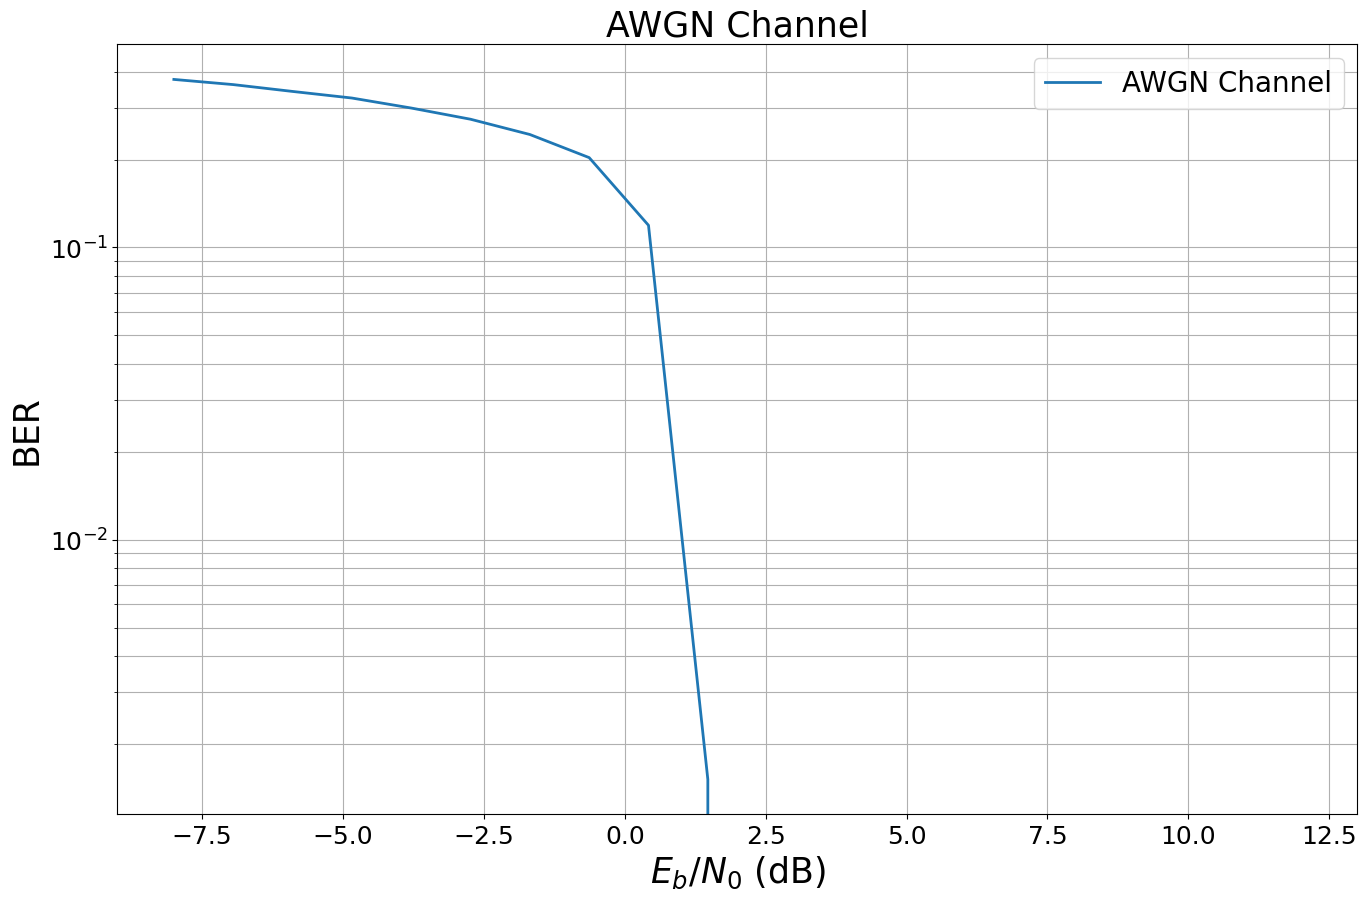

In [29]:
EBN0_DB_MIN = -8.0  # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 12.0   # Maximum value of Eb/N0 [dB] for simulations

# Initialize BER plot utility
ber_plots = sn.utils.PlotBER("AWGN Channel")

# Create an instance of AWGNSystem
model_awgn = AWGNSystem()

# Simulate BER performance
ber_plots.simulate(model_awgn,
                   ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                   batch_size=BATCH_SIZE,
                   num_target_block_errors=100,  # Simulate until 100 block errors occurred
                   legend="AWGN Channel",
                   soft_estimates=False,  # AWGN does not involve soft estimation like OFDM
                   max_mc_iter=300,  # Run 100 Monte-Carlo simulations (each with batch_size samples)
                   show_fig=False)

# Display the BER plot
ber_plots();


In [42]:
from skimage import data
data.camera() 
from skimage.color import rgb2gray
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from PIL import Image
import sionna as sn

class OFDMSystemImage(Model):  # Inherits from Keras Model

    def __init__(self, perfect_csi):
        super().__init__()  # Must call the Keras model initializer

        self.perfect_csi = perfect_csi
        self.image = data.camera() 

        n = int(RESOURCE_GRID.num_data_symbols * NUM_BITS_PER_SYMBOL)  # Number of coded bits
        k = int(n * CODERATE)  # Number of information bits
        self.k = k
        self.n = n

        # Binary source to create batches of information bits
        self.binary_source = sn.utils.BinarySource()

        # Encoder for LDPC coding
        self.encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

        # Mapper for QAM modulation
        self.mapper = sn.mapping.Mapper("qam", NUM_BITS_PER_SYMBOL)

        # Resource grid mapper
        self.rg_mapper = sn.ofdm.ResourceGridMapper(RESOURCE_GRID)

        # Frequency domain OFDM channel
        self.channel = sn.channel.OFDMChannel(CDL, RESOURCE_GRID, add_awgn=True, normalize_channel=True, return_channel=True)

        # LS channel estimator
        self.ls_est = sn.ofdm.LSChannelEstimator(RESOURCE_GRID, interpolation_type="nn")

        # LMMSE equalizer
        self.lmmse_equ = sn.ofdm.LMMSEEqualizer(RESOURCE_GRID, STREAM_MANAGEMENT)

        # Demapper for QAM
        self.demapper = sn.mapping.Demapper("app", "qam", NUM_BITS_PER_SYMBOL)

        # LDPC decoder for decoding received bits
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=True)

    @tf.function  # Graph execution for efficiency
    def __call__(self, input_bits, ebno_db):
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=NUM_BITS_PER_SYMBOL, coderate=CODERATE, resource_grid=RESOURCE_GRID)

        # Transmitter
        codewords = self.encoder(input_bits)
        x = self.mapper(codewords)
        x_rg = self.rg_mapper(x)

        # Channel
        y, h_freq = self.channel([x_rg, no])

        # Receiver
        if self.perfect_csi:
            h_hat, err_var = h_freq, 0.0
        else:
            h_hat, err_var = self.ls_est([y, no])
        x_hat, no_eff = self.lmmse_equ([y, h_hat, err_var, no])
        llr = self.demapper([x_hat, no_eff])
        output_bits = self.decoder(llr)

        return output_bits
    
    def preprocess_image(self):
        image = self.image
        """Preprocess an image: resize, convert to grayscale if needed, and flatten into binary bits."""
        if len(image.shape) == 3:  # Convert color image to grayscale
            image = rgb2gray(image)
        image = resize(image, (128, 128), anti_aliasing=True)  # Resize for simplicity
        image = (image * 255).astype(np.uint8)  # Scale to 0-255
        flat_bits = np.unpackbits(image.flatten())
        # Pad to match the system's input size
        num_bits = len(flat_bits)
        pad_bits = (self.k - (num_bits % self.k)) % self.k
        flat_bits = np.pad(flat_bits, (0, pad_bits), 'constant')
        self.flat_bits = flat_bits
        self.img_shape = image.shape


    def reconstruct_image(self):
        """Reconstruct an image from binary bits and reshape to original dimensions."""
        num_pixels = np.prod(self.img_shape)
        pixels = np.packbits(bits[:num_pixels])
        img_array = pixels.reshape(self.img_shape)
        return Image.fromarray(img_array.astype(np.uint8))



model = OFDMSystemImage(perfect_csi=False)
model.preprocess_image()
model.reconstruct_image()

> /var/folders/4s/b7gb8z5553b490xvx_76pv6m0000gn/T/ipykernel_39320/861595946.py(94)reconstruct_image()
     93         import ipdb; ipdb.set_trace()
---> 94         pixels = np.packbits(bits[:num_pixels])
     95         img_array = pixels.reshape(self.img_shape)



ipdb>  num_pixels


16384


ipdb>  bits


<tf.Tensor: shape=(128, 1, 1, 912), dtype=float32, numpy=
array([[[[1., 1., 1., ..., 1., 1., 1.]]],


       [[[0., 1., 0., ..., 0., 0., 0.]]],


       [[[0., 1., 0., ..., 1., 0., 0.]]],


       ...,


       [[[0., 1., 1., ..., 1., 0., 1.]]],


       [[[1., 0., 1., ..., 0., 1., 0.]]],


       [[[1., 1., 0., ..., 0., 0., 1.]]]], dtype=float32)>


ipdb>  pixels = np.packbits(bits[:num_pixels])


*** TypeError: Expected an input array of integer or boolean data type
--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user



KeyboardInterrupt

